# Problem 1
## Part 0: Fit A Good Model

In [21]:
import pprint as pp
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from numpy import linalg as LA
from xgboost import plot_tree
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
filename = 'cs-training.csv'
data = pd.read_csv(filename)

In [3]:
data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


In [5]:
# This is just an id column
#data['Unnamed: 0']
data.drop(['Unnamed: 0'], inplace=True, axis=1)

First we check for NaN and other oddities.

In [6]:
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
#data.MonthlyIncome.isnull()
data.MonthlyIncome.iloc[6]

nan

Lets make these zeros, as it's more likely that a non-response means no income than a median or mean income.

In [8]:
data.MonthlyIncome.fillna(0, inplace=True)

For dependents, lets fill NaN with the mean, as most people have either 0 or 1 dependent, and its difficult to judge which one is more appropriate here.

In [9]:
# Just a check to make sure that there are both zero and 
# one entries. If there were no zero entries then maybe the 
# NaN entries should be zero.
#data.NumberOfDependents.value_counts()

data.NumberOfDependents.fillna(data.NumberOfDependents.mean(), inplace=True)

In [10]:
# Double check
#data.isnull().sum()

Now lets take a look at the labels and their balance.

In [11]:
data.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Big imbalance here. Let's make a hold out set and train XGBoost. We can play with the `scale_pos_weight` parameter to take care of the imbalance. First I am renaming this column because it's annoying to keep typing.

In [12]:
data['label'] = data.SeriousDlqin2yrs
data.drop(['SeriousDlqin2yrs'], inplace=True, axis=1)

In [13]:
# Ratio of 0's to 1's
ratio = data.label.value_counts().iloc[0] / data.label.value_counts().iloc[1]

In [14]:
msk = np.random.rand(len(data)) < 0.8
train_data = data[msk]
validation = data[~msk]

In [15]:
features = train_data.drop(['label'], axis=1)
labels = train_data.label

In [137]:
accuracies = [] 
aucs = [] 
val_acc = []
val_auc = []

num_splits = 5
depths = [2, 3, 4, 5, 6, 7, 8]

for i in range(len(depths)):
    print('Evaluating tree of depth {}'.format(depths[i]))
    accuracy = [] 
    auc = [] 
    kf = KFold(n_splits=5)
    _ = kf.get_n_splits(features, labels)
    for train_index, test_index in kf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        params = {'max_depth':depths[i], 'eta':0.05, 'gamma':1.5, 'silent':1, 
                 'objective':'binary:logistic', 'early_stopping_rounds':5, 
                 'scale_pos_weight':ratio}
        num_round = 800

        dtrain = xgb.DMatrix(X_train, y_train)
        dtest = xgb.DMatrix(X_test, y_test)
        model = xgb.train(params, dtrain, num_round)
        pred = model.predict(dtest)
        fpr_temp, tpr_temp, thresholds = metrics.roc_curve(y_test, pred)
        auc_temp = metrics.auc(fpr_temp, tpr_temp)
        accuracy.append(metrics.accuracy_score(y_test, pred.round()))
        auc.append(np.array(auc_temp).mean())

    # Grab the mean CV score and validation score
    dtest = xgb.DMatrix(validation.drop(['label'], axis=1), validation.label)
    pred = model.predict(dtest)
    val_acc.append(metrics.accuracy_score(validation.label, pred.round()))
    fpr, tpr, thresholds = metrics.roc_curve(validation.label, pred)
    val_auc.append(metrics.auc(fpr, tpr))
    accuracies.append(np.array(accuracy).mean())
    aucs.append(np.array(auc).mean())

Evaluating tree of depth 2
Evaluating tree of depth 3
Evaluating tree of depth 4
Evaluating tree of depth 5
Evaluating tree of depth 6
Evaluating tree of depth 7
Evaluating tree of depth 8


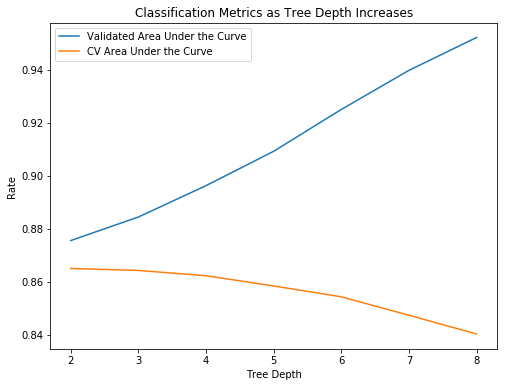

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
#_ = plt.plot(depths, val_acc, label='Validated Accuracy')
_ = plt.plot(depths, val_auc, label='Validated Area Under the Curve')
#_ = plt.plot(depths, accuracies, label='CV Accuracy')
_ = plt.plot(depths, aucs, label='CV Area Under the Curve')
_ = plt.title('Classification Metrics as Tree Depth Increases')
_ = plt.xlabel('Tree Depth')
_ = plt.ylabel('Rate')
_ = plt.legend()

Interesting. Lets keep running higher depths.

In [140]:
accuracies = [] 
aucs = [] 
val_acc = []
val_auc = []

num_splits = 5
depths = [9, 10, 11, 12]

for i in range(len(depths)):
    print('Evaluating tree of depth {}'.format(depths[i]))
    accuracy = [] 
    auc = [] 
    kf = KFold(n_splits=5)
    _ = kf.get_n_splits(features, labels)
    for train_index, test_index in kf.split(features, labels):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        params = {'max_depth':depths[i], 'eta':0.05, 'gamma':1.5, 'silent':1, 
                 'objective':'binary:logistic', 'early_stopping_rounds':5, 
                 'scale_pos_weight':ratio}
        num_round = 800

        dtrain = xgb.DMatrix(X_train, y_train)
        dtest = xgb.DMatrix(X_test, y_test)
        model = xgb.train(params, dtrain, num_round)
        pred = model.predict(dtest)
        fpr_temp, tpr_temp, thresholds = metrics.roc_curve(y_test, pred)
        auc_temp = metrics.auc(fpr_temp, tpr_temp)
        accuracy.append(metrics.accuracy_score(y_test, pred.round()))
        auc.append(np.array(auc_temp).mean())

    # Grab the mean CV score and validation score
    dtest = xgb.DMatrix(validation.drop(['label'], axis=1), validation.label)
    pred = model.predict(dtest)
    val_acc.append(metrics.accuracy_score(validation.label, pred.round()))
    fpr, tpr, thresholds = metrics.roc_curve(validation.label, pred)
    val_auc.append(metrics.auc(fpr, tpr))
    accuracies.append(np.array(accuracy).mean())
    aucs.append(np.array(auc).mean())

Evaluating tree of depth 9
Evaluating tree of depth 10
Evaluating tree of depth 11
Evaluating tree of depth 12


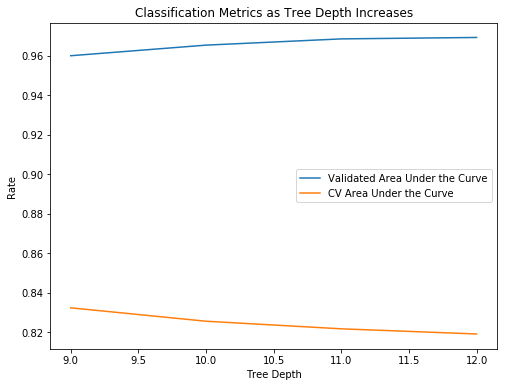

In [141]:
fig, ax = plt.subplots(figsize=(8,6))
#_ = plt.plot(depths, val_acc, label='Validated Accuracy')
_ = plt.plot(depths, val_auc, label='Validated Area Under the Curve')
#_ = plt.plot(depths, accuracies, label='CV Accuracy')
_ = plt.plot(depths, aucs, label='CV Area Under the Curve')
_ = plt.title('Classification Metrics as Tree Depth Increases')
_ = plt.xlabel('Tree Depth')
_ = plt.ylabel('Rate')
_ = plt.legend()

In the interest of not overfitting, lets call a depth of 9 our best model.

In [19]:
dtrain = xgb.DMatrix(features, labels)
model = xgb.train({'max_depth':9, 'eta':0.05, 'gamma':1.5, 'silent':1, 
                 'objective':'binary:logistic', 'early_stopping_rounds':5, 
                 'scale_pos_weight':ratio}, dtrain, 800)

## Part 1: What Is The Effect of Monthly Income

We can fit a logistic regression to the model and take a look at how the coefficient weights change.

In [61]:
features = data.drop(['label'], axis=1)
labels = data.label

In [116]:
clf = LogisticRegression(penalty='l2', max_iter=1000)
_ = clf.fit(features, labels)
coef = clf.coef_

In [125]:
coef = np.reshape(coef, (10,))
ratios = np.empty(len(coef))
for i in range(len(coef)):
    ratios[i] = coef[i]/LA.norm(coef, 1)

In [127]:
weights = dict(zip(list(features), ratios))

In [136]:
#len(features.columns)
#len(np.array(ratios))
pp.pprint(weights)

{'DebtRatio': -3.7332330480092064e-05,
 'MonthlyIncome': -1.7724991697768557e-05,
 'NumberOfDependents': 0.036674525945664095,
 'NumberOfOpenCreditLinesAndLoans': -0.0058454359873438295,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.22071275829988726,
 'NumberOfTime60-89DaysPastDueNotWorse': -0.4415152796857481,
 'NumberOfTimes90DaysLate': 0.23406659894507753,
 'NumberRealEstateLoansOrLines': 0.04287726912841594,
 'RevolvingUtilizationOfUnsecuredLines': -2.2786898632826526e-05,
 'age': -0.018230287787052542}


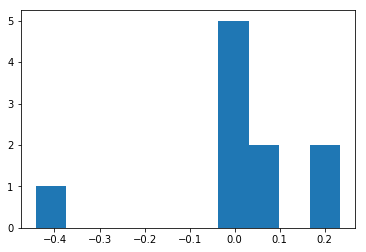

In [138]:
_ = plt.hist(ratios)

From our printed dictionary we can see how the coefficient weights are set by the model. Looking specifically at the coefficient for `MonthlyIncome` we can see that the coefficient is $-1.7 x 10^{-5}$. This tells us that earning an additional \$1000 per month reduces the probability of delinquency by $1.7 x 10^{-2}$  or   $0.017 \,\,percent$. Earning an additional \$2000 per month reduces the probability of delinquency by  $3.4 x 10^{-2}$   or   $0.034 \,\,percent$. Earning an additional \$3000 per month reduces the probability of delinquency by   $0.051\,\, percent$.

In [23]:
#plot_tree(model)
# TODO -- graphviz site is down

## Part 2 Most Important Variable

We can see that the variable with the largest effect is the number of times a person was 60-89 days past due. Interestingly, this variable has the effect of lowering a persons chance of delinquincy. This must be because it has a "not worse" clause. The second most important variable is the number of times a person was more than 90 days late. We can see this from the size of the coefficients relative the others.

## Part 3 Age Discrimination